# ЗАДАНИЕ 8. ПОСТРОЕНИЕ МОДЕЛИ ARIMA

In [288]:
import os
import pandas as pd 
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import scipy.stats
from scipy.stats import t as student
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

In [289]:
os.chdir("C:/Users/HP/Documents/analysis/TS/data/")

In [290]:
data = pd.read_excel('data.xls', sheet_name='Material 3')
data.head()

,Unnamed: 0,Unnamed: 1,Рыночные цены на материал 3 (руб.),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,NaN,NaN,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,...,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00
1,№ организации,1.0,10.07,10.04,10.05,10.05,10.03,10.03,10.06,10.03,...,10.18,10.18,10.16,10.17,10.14,10.16,10.12,10.14,10.12,10.15
2,NaN,2.0,10,10.25,10.23,10.39,10.22,10.16,9.99,9.91,...,8.84,8.78,8.7,8.55,8.61,8.85,8.77,8.55,8.44,8.21
3,NaN,3.0,78.79,78.93,78.81,78.7,78.63,78.76,78.6,78.7,...,79.02,79.12,79.09,79.16,79.28,79.1,79.22,79.33,79.09,79.09
4,NaN,4.0,85.22,85.34,85.29,85.38,85.6,85.46,85.5,85.27,...,86.25,86.43,86.22,86.11,86.12,86.17,86.35,86.53,86.33,86.37


In [291]:
dates = data.loc[data.index == 0].values[0, 2:]
val = data.loc[data.index == 1].values[0, 2:]

In [292]:
data={"Date": dates, "Value": val}

In [293]:
my_data = pd.DataFrame(data)
my_data.head()

,Date,Value
0,2007-01-01,10.07
1,2007-02-01,10.04
2,2007-03-01,10.05
3,2007-04-01,10.05
4,2007-05-01,10.03


In [294]:
my_data=my_data.set_index('Date')
my_data.head()

,Value
Date,
2007-01-01,10.07
2007-02-01,10.04
2007-03-01,10.05
2007-04-01,10.05
2007-05-01,10.03


In [295]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Value   48 non-null     object
dtypes: object(1)
memory usage: 768.0+ bytes


In [296]:
my_data.Value=my_data.Value.astype(float)

In [297]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [298]:
series=my_data.squeeze()
type(series)

pandas.core.series.Series

# Методология построения модели ARIMA

## Шаг 1. Получить стационарный ряд

<AxesSubplot:xlabel='Date'>

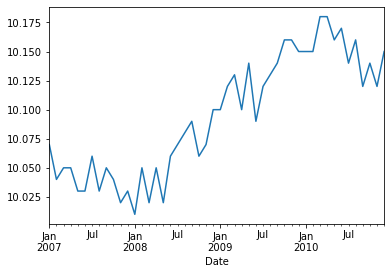

In [299]:
series.plot()

Видим, что исходный ряд не стационарный - в нем присутствует тренд. Мы можем это подтвердить с использованием расширенного теста Дики-Фуллера. 

In [300]:
# calculate the stationarity 
# statistical test
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.748812
p-value: 0.833698
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


Нулевая гипотеза теста заключается в том, что временной ряд нестационарен. p-value=0.833698 > 0.05. Поэтому нулевую гипотезу не отвергаем.

#### Decompose Time Series Data

Декомпозиция временных рядов предполагает рассмотрение ряда как комбинации уровня, тренда, сезонности, и шумовой составляющей.

Эти компоненты определяется следующим образом:
* Уровень - среднее значение временного ряда.
* Тренд - возрастающая или убывающая тенденция ряда.
* Сезонность - периодическая составляющая ряда.
* Шум - случайная составляющая ряда. 

Компоненты можно собрать в единое целое аддитивно или мультипликативно. Модель ARIMA может быть построена, если ряд включает аддитивно трендовую составляющую, имеющую вид алгебраического полинома.

Аддитивная модель предполагает, что компоненты ряда складываются следующим образом: y(t) = Level + Trend + Seasonality + Noise

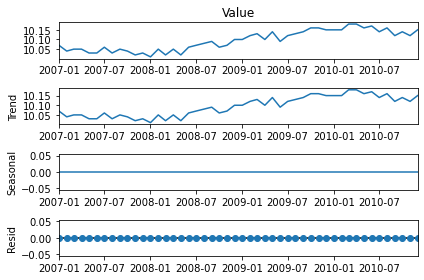

In [301]:
# additive decompose a contrived additive time series
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
plt.show()

Вывод - есть только тренд. Попробуем определить порядок полинома, который наилучшим образом его опишет.

### Use and Remove Trends

Возможно, самый простой способ избавиться от тренда во временном ряду - это провести дифференцирование. В частности, строится новый ряд, в котором значение на текущем временном шаге рассчитывается как разность между исходным наблюдением и наблюдением на предыдущем временном шаге: value(t) = observation(t) - observation(t - 1)

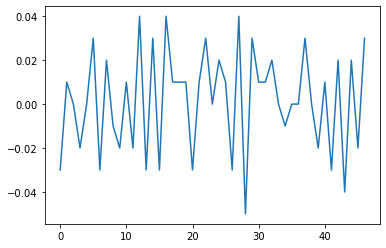

In [302]:
# detrend a time series using differencing
X = series.values
diff = list()
for i in range(1, len(X)):
	value = X[i] - X[i - 1]
	diff.append(value)
plt.plot(diff)
plt.show()

Прогнозы на основе модели линейного (или нелинейного) тренда можно вычесть из исходного временного ряда, чтобы
получить набор данных без тренда: value(t) = observation(t) - prediction(t)

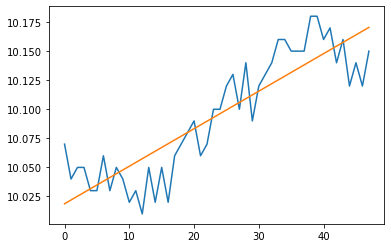

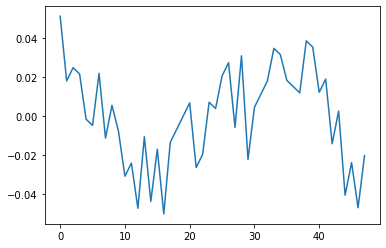

In [303]:
# use a linear model to detrend a time series
# fit linear model
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(series))]
# plot detrended
plt.plot(detrended)
plt.show()

In [304]:
# calculate the stationarity 
# statistical test
result = adfuller(detrended)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.903053
p-value: 0.330626
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


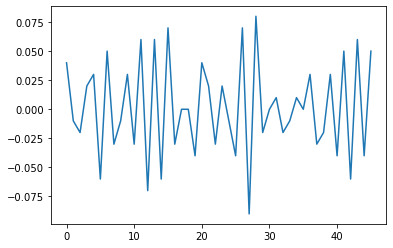

In [305]:
# detrend a time series using 2 differencing
diff2 = list()
for i in range(1, len(diff)):
	value = diff[i] - diff[i - 1]
	diff2.append(value)
plt.plot(diff2)
plt.show()

In [306]:
# calculate the stationarity 
# statistical test
result = adfuller(diff2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.697034
p-value: 0.000000
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606


Ряд стационарный. Следовательно, в модели ARIMA i попробовать на уровнях 1 и 2.

## Шаг 2. Выдвигаются гипотезы о значениях параметров p (порядок авторегрессии) и q (порядок скользящего среднего)

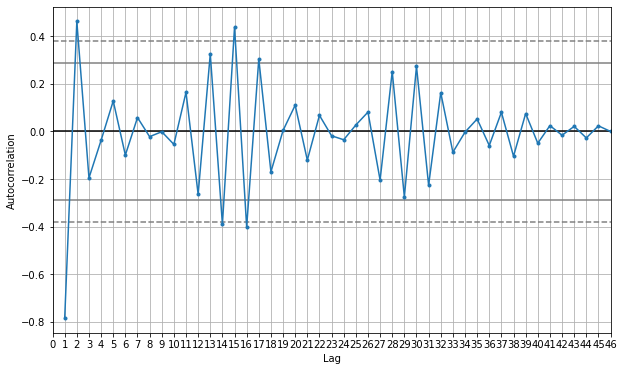

In [307]:
fig, ax = plt.subplots(figsize = (10, 6))

autocorrelation_plot(diff2, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlim(0, len(diff2))

plt.show()

In [308]:
max_tau=int(len(diff2)/4)
max_tau

11

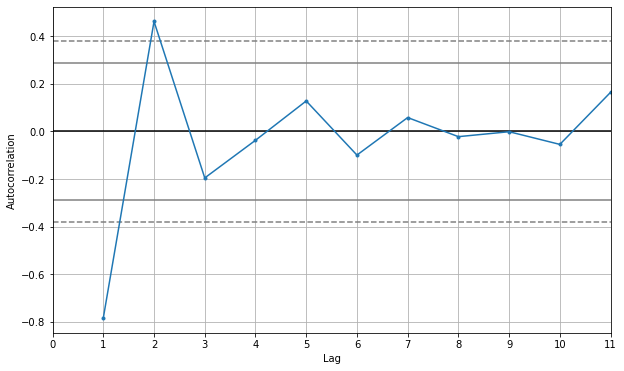

In [309]:
fig, ax = plt.subplots(figsize = (10, 6))

autocorrelation_plot(diff2, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlim(0, max_tau)

plt.show()

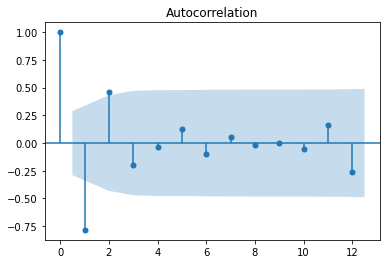

In [310]:
# autocorrelation plot of time series
plot_acf(diff2, lags=12)
plt.show()

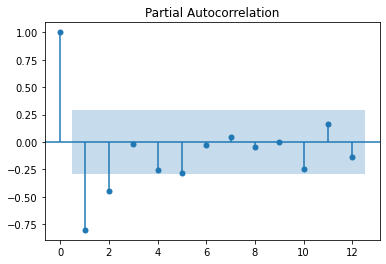

In [311]:
# autocorrelation plot of time series
plot_pacf(diff2, lags=12)
plt.show()

Вывод: в модели ARIMA попробовать p, равным 1 и 2.

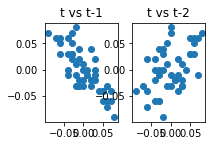

In [312]:
# create multiple scatter plots
values = pd.DataFrame(diff2)
lags = 2
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
	ax = plt.subplot(240 + i)
	ax.set_title('t vs t-' + str(i))
	plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.show()

In [337]:
modelp = ar_select_order(diff2, maxlag=max_tau,old_names=False)
modelp.ar_lags

array([1, 2, 3, 4, 5])

Вывод: в модели ARIMA попробовать p, равным 1-5.

Coefficients: [ 1.22581982e-03 -1.38104789e+00 -9.07262607e-01 -7.61442832e-01
 -9.45509889e-01 -5.27397368e-01]
predicted=0.036115, expected=0.010000
predicted=-0.033804, expected=0.000000
predicted=0.036396, expected=0.030000
predicted=-0.025866, expected=-0.030000
predicted=0.000794, expected=-0.020000
predicted=0.008798, expected=0.030000
predicted=-0.008534, expected=-0.040000
predicted=0.009687, expected=0.050000
predicted=0.001783, expected=-0.060000
predicted=-0.012263, expected=0.060000
predicted=0.012598, expected=-0.040000
predicted=-0.011062, expected=0.050000
Test RMSE: 0.042


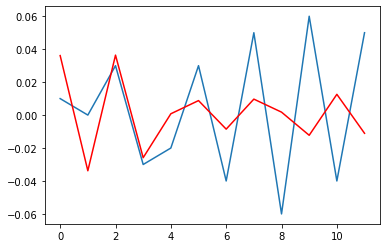

In [315]:
# create and evaluate a static autoregressive model
# split dataset
X = diff2
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
model = AutoReg(train, lags=modelp.ar_lags,old_names=False)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [316]:
err=model_fit.resid
err

array([-0.00523719, -0.01582613,  0.01459635, -0.01406745, -0.01509071,
       -0.00607864,  0.03495077, -0.01801456,  0.01678462, -0.00872813,
        0.02795474,  0.0221565 , -0.00502267, -0.00022945, -0.02952725,
       -0.00791522,  0.02190367,  0.00222793, -0.01187469,  0.02113062,
       -0.01972824,  0.00187115, -0.03536912, -0.01137661,  0.01781101,
        0.02029417,  0.00336628,  0.00553083, -0.00649256])

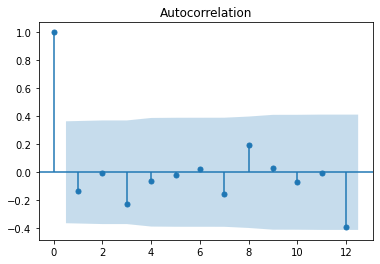

In [317]:
# autocorrelation plot of errors
plot_acf(err, lags=12)
plt.show()

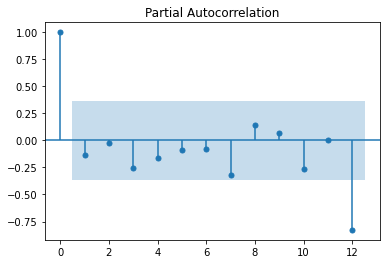

In [318]:
# autocorrelation plot of errors
plot_pacf(err, lags=12)
plt.show()

In [319]:
modelq = ar_select_order(err, maxlag=max_tau,old_names=False)
modelq.ar_lags

array([], dtype=int32)

Вывод: в модели ARIMA попробовать q, равным 0.

Таким рбразом, рассмотреть следующие возможные значения параметров модели ARIMA:
p = [1, 2, 3, 4, 5]
i = [1, 2]
q = 0

## Шаг 3. Оценка параметров моделей ARIMA

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                   46
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 109.964
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 02 Dec 2021   AIC                           -211.928
Time:                        18:36:02   BIC                           -204.614
Sample:                    03-01-2007   HQIC                          -209.188
                         - 12-01-2010                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.001      0.232      0.816      -0.002       0.003
ar.L1.D2.Value    -1.1850      0.130     -9.094      0.000      -1.440      -0.930
ar.L2.D2.Value    -0.4650      0.130

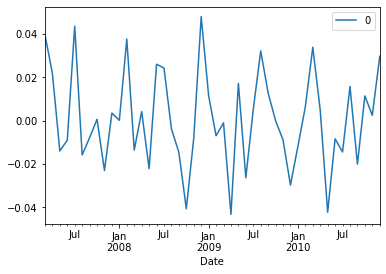

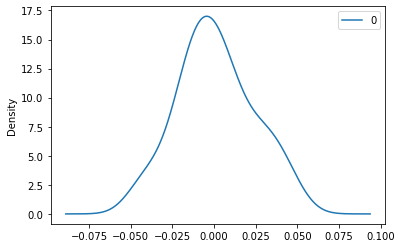

               0
count  46.000000
mean    0.000996
std     0.022632
min    -0.043309
25%    -0.013910
50%     0.000039
75%     0.015030
max     0.048037


In [334]:
# fit an ARIMA model and plot residual errors
# fit model
model = ARIMA(series, order=(2,2,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)

predicted=10.098890, expected=10.130000
predicted=10.118710, expected=10.140000
predicted=10.162722, expected=10.160000
predicted=10.169634, expected=10.160000
predicted=10.180575, expected=10.150000
predicted=10.163318, expected=10.150000
predicted=10.143443, expected=10.150000
predicted=10.145169, expected=10.180000
predicted=10.175943, expected=10.180000
predicted=10.201712, expected=10.160000
predicted=10.178914, expected=10.170000
predicted=10.155582, expected=10.140000
predicted=10.141140, expected=10.160000
predicted=10.141647, expected=10.120000
predicted=10.125896, expected=10.140000
predicted=10.118053, expected=10.120000
predicted=10.118000, expected=10.150000
Test RMSE: 0.022


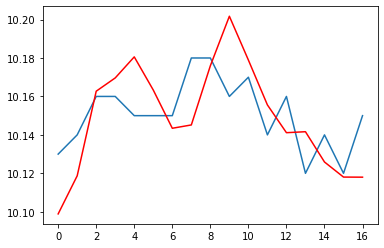

In [335]:
# evaluate an ARIMA model using a walk-forward validation
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,2,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)

## Шаг 4. Проверка адекватности моделей ARIMA

## Grid Search ARIMA Model Hyperparameters

In [322]:
# grid search ARIMA parameters for time series
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 4, 5]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2]
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.073
ARIMA(0, 0, 1) RMSE=0.050
ARIMA(0, 0, 2) RMSE=0.035
ARIMA(0, 1, 0) RMSE=0.020
ARIMA(0, 1, 1) RMSE=0.019
ARIMA(0, 1, 2) RMSE=0.019
ARIMA(0, 2, 0) RMSE=0.034
ARIMA(0, 2, 1) RMSE=0.021
ARIMA(1, 0, 0) RMSE=0.022
ARIMA(1, 0, 2) RMSE=0.021
ARIMA(1, 1, 0) RMSE=0.018
ARIMA(1, 1, 1) RMSE=0.018
ARIMA(1, 1, 2) RMSE=0.019
ARIMA(1, 2, 0) RMSE=0.022
ARIMA(1, 2, 1) RMSE=0.020
ARIMA(1, 2, 2) RMSE=0.021
ARIMA(2, 0, 0) RMSE=0.019
ARIMA(2, 1, 0) RMSE=0.018
ARIMA(2, 1, 2) RMSE=0.019
ARIMA(2, 2, 0) RMSE=0.022
ARIMA(2, 2, 1) RMSE=0.020
ARIMA(2, 2, 2) RMSE=0.020
ARIMA(4, 1, 0) RMSE=0.018
ARIMA(4, 1, 1) RMSE=0.018
ARIMA(4, 1, 2) RMSE=0.021
ARIMA(4, 2, 0) RMSE=0.021
ARIMA(4, 2, 1) RMSE=0.020
ARIMA(5, 0, 0) RMSE=0.019
ARIMA(5, 1, 0) RMSE=0.019
ARIMA(5, 1, 1) RMSE=0.018
ARIMA(5, 1, 2) RMSE=0.021
ARIMA(5, 2, 0) RMSE=0.019
ARIMA(5, 2, 1) RMSE=0.019
ARIMA(5, 2, 2) RMSE=0.019
Best ARIMA(1, 1, 0) RMSE=0.018


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                   47
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 120.273
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 02 Dec 2021   AIC                           -234.546
Time:                        18:35:12   BIC                           -228.996
Sample:                    02-01-2007   HQIC                          -232.458
                         - 12-01-2010                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0017      0.002      1.018      0.309      -0.002       0.005
ar.L1.D.Value    -0.6119      0.118     -5.200      0.000      -0.843      -0.381
                                    Root

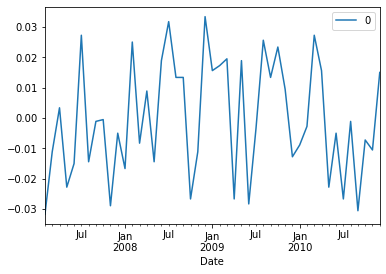

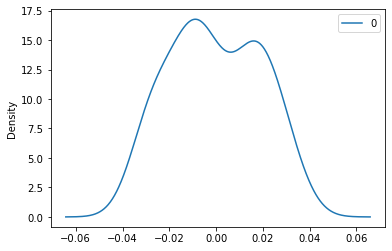

               0
count  47.000000
mean   -0.000413
std     0.019044
min    -0.031730
25%    -0.014431
50%    -0.002789
75%     0.015569
max     0.033331


In [323]:
# fit an ARIMA model and plot residual errors
# fit model
model = ARIMA(series, order=(1,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

# Forecast Confidence Intervals

In [324]:
# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit(disp=False)
# forecast
forecast, stderr, conf = model_fit.forecast()
# summarize forecast and confidence intervals
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)

Expected: 10.150
Forecast: 10.134
Standard Error: 0.019
95% Confidence Interval: 10.098 to 10.171


In [325]:
# summarize multiple confidence intervals on an ARIMA forecast
# split data into train and test setes
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit(disp=False)
# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
	forecast, stderr, conf = model_fit.forecast(alpha=a)
	print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))

80.0% Confidence Interval: 10.134 between 10.110 and 10.158
90.0% Confidence Interval: 10.134 between 10.104 and 10.165
95.0% Confidence Interval: 10.134 between 10.098 and 10.171
99.0% Confidence Interval: 10.134 between 10.086 and 10.183


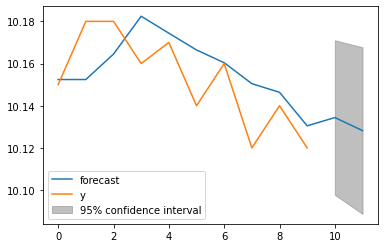

In [326]:
# plot the confidence intervals for an ARIMA forecast
# split into train and test sets
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit(disp=False)
# plot some history and the forecast with confidence intervals
model_fit.plot_predict(len(train)-10, len(train)+1)
plt.legend(loc='lower left')
plt.show()

<p><a name="Intervals"></a></p>

# Построение интервального прогноза

In [327]:
y_pred, stderr, conf=model_fit.forecast(48)

In [328]:
y_fornew, stderr_fornew, conf_fornew=model_fit.forecast(60)

In [329]:
# Точечный прогноз на год вперед
y_new=y_fornew[48:60]
y_new

array([10.20246351, 10.20398205, 10.2055006 , 10.20701914, 10.20853768,
       10.21005623, 10.21157477, 10.21309331, 10.21461185, 10.2161304 ,
       10.21764894, 10.21916748])

In [330]:
# Прогнозный интервал на год вперед
conf_new=conf_fornew[48:60]
conf_new

array([[10.03979452, 10.3651325 ],
       [10.03970423, 10.36825988],
       [10.03962954, 10.37137166],
       [10.03957   , 10.37446828],
       [10.03952521, 10.37755016],
       [10.03949474, 10.38061771],
       [10.03947821, 10.38367133],
       [10.03947526, 10.38671137],
       [10.03948552, 10.38973819],
       [10.03950866, 10.39275213],
       [10.03954436, 10.39575352],
       [10.0395923 , 10.39874266]])

In [331]:
t = np.arange(1, len(series) + 1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [332]:
t_new = np.arange(len(series) + 1,len(series)+13)
t_new=t_new.reshape(-1,1)
t_new

array([[49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60]])

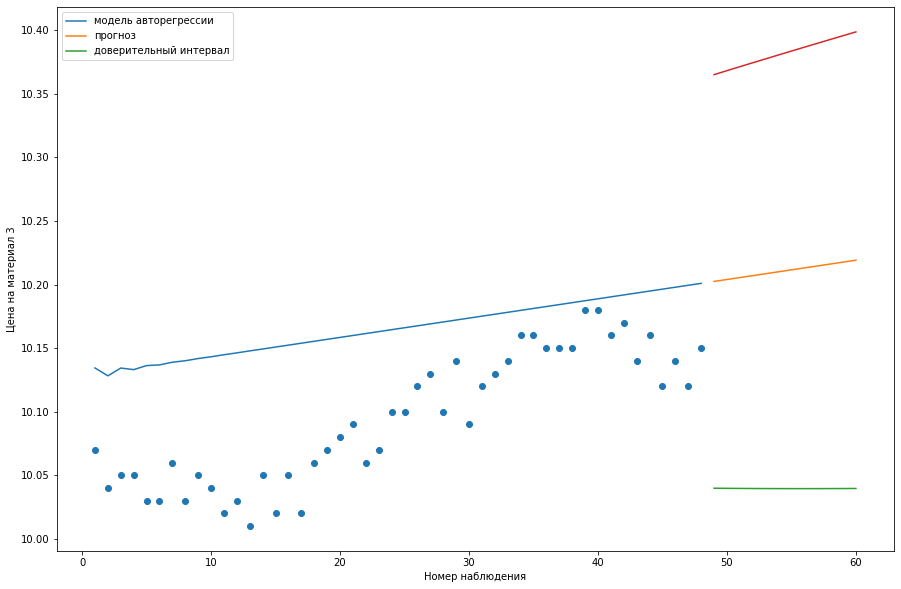

In [333]:
plt.figure(figsize=[15,10])

plt.scatter(t, series)

plt.plot(t,y_pred)
plt.plot(t_new,y_new)
plt.plot(t_new,conf_new)

plt.xlabel("Номер наблюдения")
plt.ylabel("Цена на материал 3")
plt.legend(['модель авторегрессии','прогноз','доверительный интервал'])

plt.show()